In [2]:
import torch
torch.cuda.is_available()

False

In [1]:
import logging
import time
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import pandas, numpy, random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

RuntimeError: operator torchvision::nms does not exist

In [2]:
logging.basicConfig(filename='log/train.log', level=logging.INFO)

In [3]:
device = 'cpu'

if torch.mps.is_available():
    device = 'mps'

if torch.cuda.is_available():
    device = 'cuda'

print(device)

cuda


In [4]:
def show_plt(generator, num_of_classe = 10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2행 5열 격자 생성

    for i in range(10):
        ax = axes[i // 5, i % 5]
    
        seed = torch.randn(100).to(device)
        one_hot = torch.nn.functional.one_hot(torch.tensor(i), num_of_classe).to(device)
        seed = torch.concat([seed, one_hot], dim=0).to(device)
        seed = seed.reshape(1, seed.shape[0], 1, 1)
        image = generator(seed)
        image = image.reshape(28,28).cpu() 
        
        # 예시로 각 그림에 숫자 표시
        ax.imshow(image.detach().numpy(), cmap='gray')
        ax.axis('off')  # 축 숨기기
    
    plt.tight_layout()
    plt.show()

In [5]:
class GanDataset(torch.utils.data.Dataset):
    def __init__(self, data, generator, device):
        super().__init__()
        self.data = data
        self.num_of_classes = len(data.classes)
        self.device = device
        self.generator = generator.to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        one_hot_class = torch.nn.functional.one_hot(torch.tensor([self.data[index][1]]), self.num_of_classes).reshape(-1).to(self.device)
        if np.random.rand() > 0.5:
            img = self.data[index][0].to(self.device)
            target = torch.tensor([1.]).to(self.device)
        else:
            seed = torch.rand([100]).to(self.device)
            seed = torch.cat([seed, one_hot_class])
            seed = seed.reshape(1, seed.shape[0], 1, 1)
            img = self.generator(seed).detach()
            img = img.reshape(-1, 28, 28)
            target = torch.tensor([0.]).to(self.device)
        
        return img, one_hot_class, target

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, activation, batch_norm=True, dropout=0.):
        super().__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        if activation:
            layers.append(activation())

        if dropout > 0.:
            layers.append(nn.Dropout(dropout))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [7]:
class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, out_padding, activation, batch_norm=True, dropout=0.):
        super().__init__()
        layers = []
        
        layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, out_padding, bias=(not batch_norm)))

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))

        if activation:
            layers.append(activation())

        if dropout > 0.:
            layers.append(nn.Dropout(dropout))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [8]:
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, activation, dropout_prob=0.2):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.layerNorm = nn.LayerNorm(out_features)
        if activation:
            self.activation = activation()
        else:
            self.activation = None

        if dropout_prob:
            self.dropout = nn.Dropout(dropout_prob)
        else:
            self.dropout = None

    def forward(self, x):
        x = self.linear(x)
        x = self.layerNorm(x)
        if self.activation:
            x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        return x

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.block1 = LinearBlock(794, 400, nn.ReLU)
        # self.block2 = LinearBlock(400, 200, nn.ReLU)
        self.block1 = ConvBlock(1, 16, 3, 1, 1, nn.ReLU, True, 0.2)
        self.block2 = ConvBlock(16, 32, 3, 2, 1, nn.ReLU, True, 0.2)
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.pooling(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

# class Discriminator(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.block1 = LinearBlock(784, 400, nn.ReLU)
#         self.block2 = LinearBlock(400, 200, nn.ReLU)
#         self.out = nn.Linear(200, 1)

#     def forward(self, x):
#         x = x.reshape(-1, 784)
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.out(x)
#         return x

In [10]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim= 110):
        super().__init__()
        self.block1 = TransposeConvBlock(input_dim, input_dim * 2, 3, 1, 0, 0, nn.ReLU, True, 0.2) # 1 -> 3
        self.block2 = TransposeConvBlock(input_dim * 2, input_dim * 4, 3, 2, 0, 0, nn.ReLU, True, 0.2) # 3 -> 7
        self.block3 = TransposeConvBlock(input_dim * 4, input_dim, 4, 2, 1, 0, nn.ReLU, True, 0.2) # 7 -> 14
        self.block4 = TransposeConvBlock(input_dim, 1, 4, 2, 1, 0, nn.Tanh, False, 0.) # 14 -> 28

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x

g = Generator()
test = torch.rand(1, 110, 1, 1)
g(test).shape

torch.Size([1, 1, 28, 28])

In [11]:
def train_step(model, x, target, criterion, optimizer):
    model.train()
    pred = model(x)
    loss = criterion(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [12]:
mnist_dataset = datasets.MNIST(root = "./", download = True, train = True, transform = transforms.ToTensor())

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

dataset = GanDataset(mnist_dataset, generator, device)
loader = DataLoader(dataset, batch_size=2, shuffle=True, drop_last=True)

criterion = torch.nn.BCEWithLogitsLoss()
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
genr_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

0it [00:00, ?it/s]

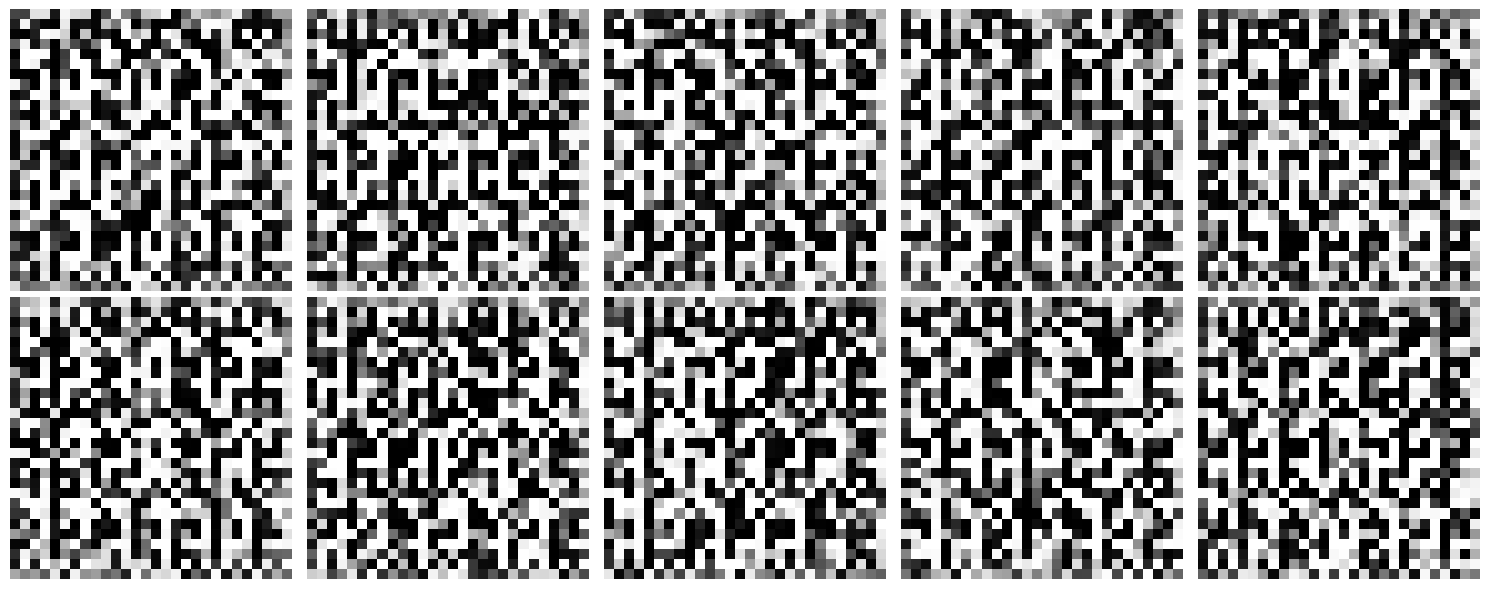

9991it [01:07, 143.02it/s, 1 / 20, disc_loss: 0.4214, gen_loss: 0.7394]

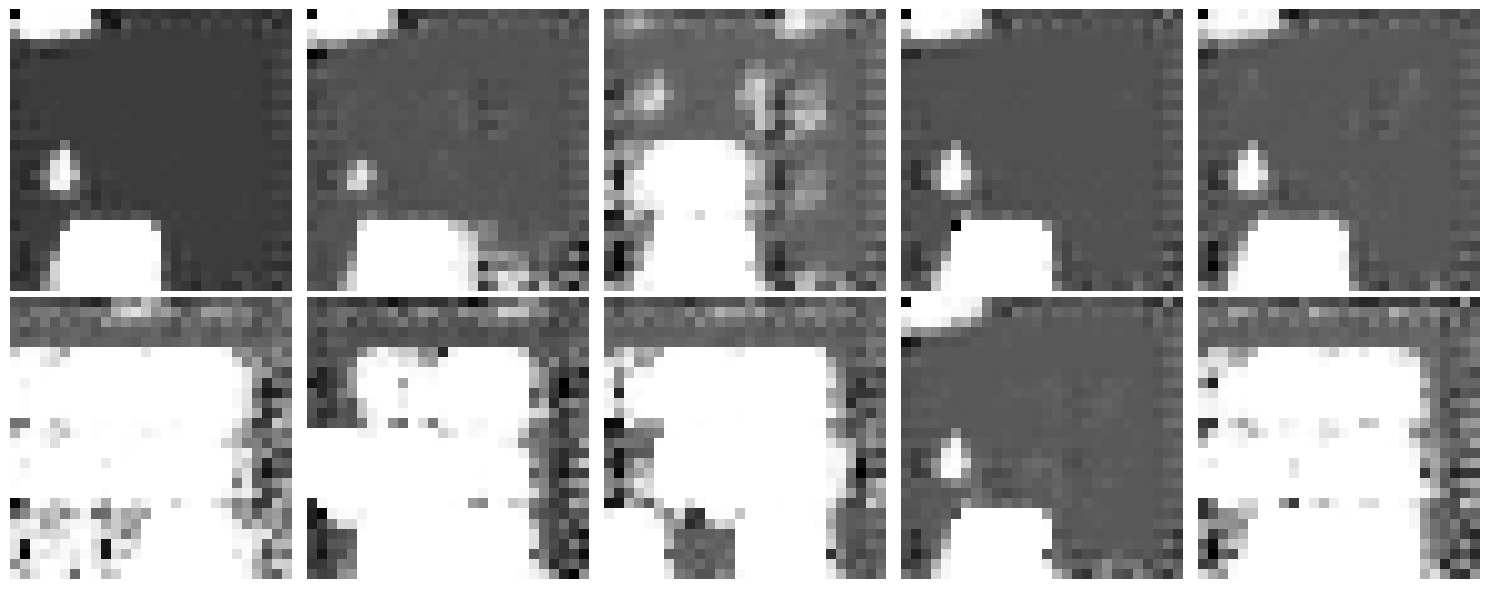

20000it [02:15, 146.22it/s, 1 / 20, disc_loss: 0.4682, gen_loss: 0.7341]

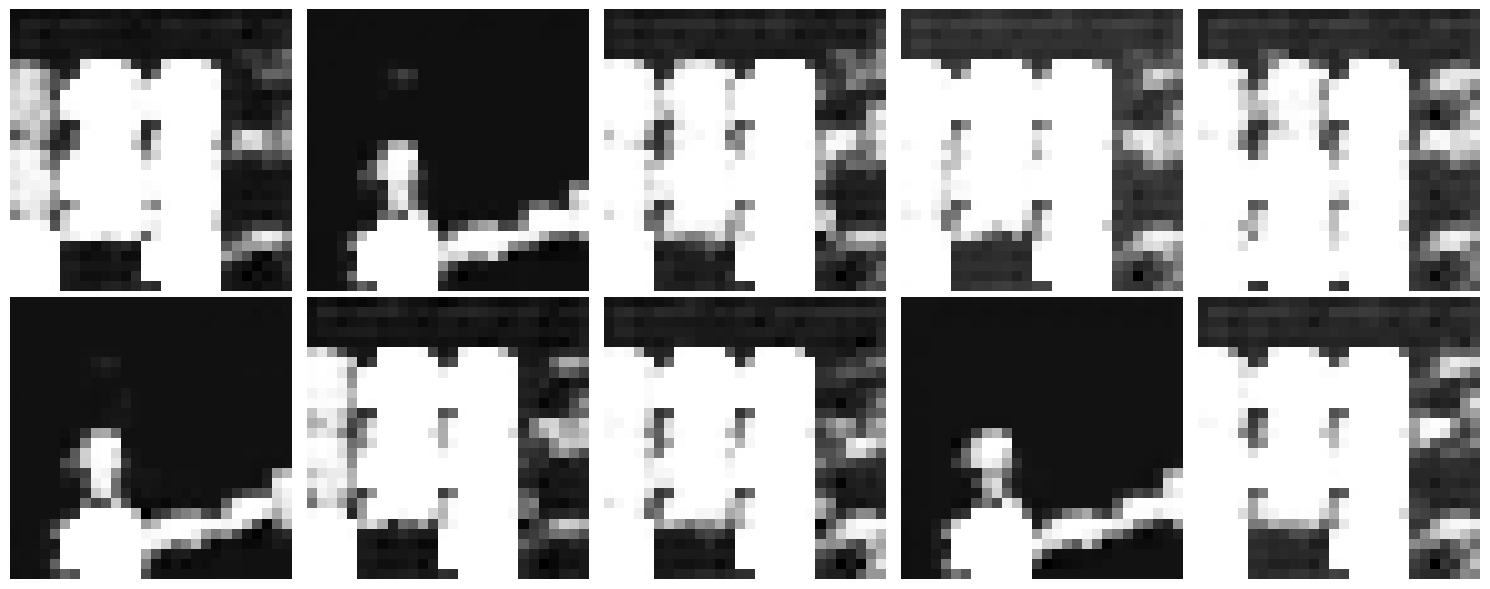

30000it [03:25, 146.17it/s, 1 / 20, disc_loss: 0.4608, gen_loss: 0.7361]
0it [00:00, ?it/s]

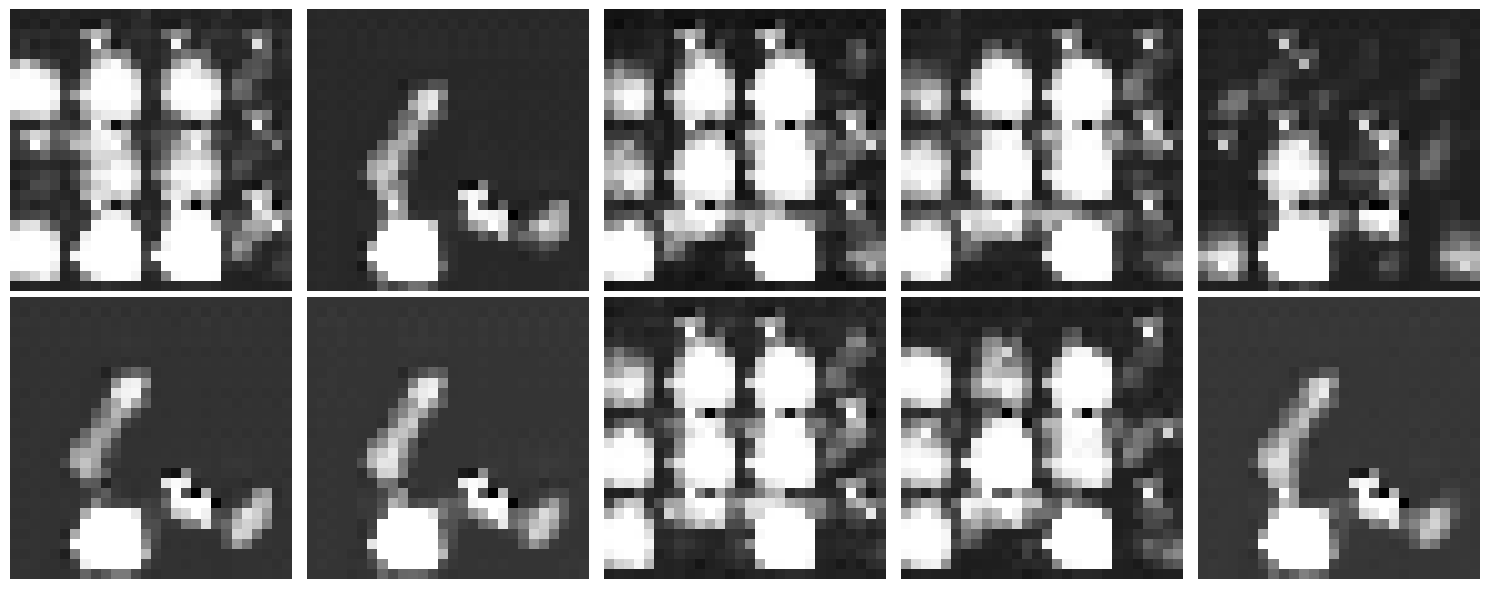

9993it [01:08, 151.71it/s, 2 / 20, disc_loss: 0.5236, gen_loss: 0.6969]

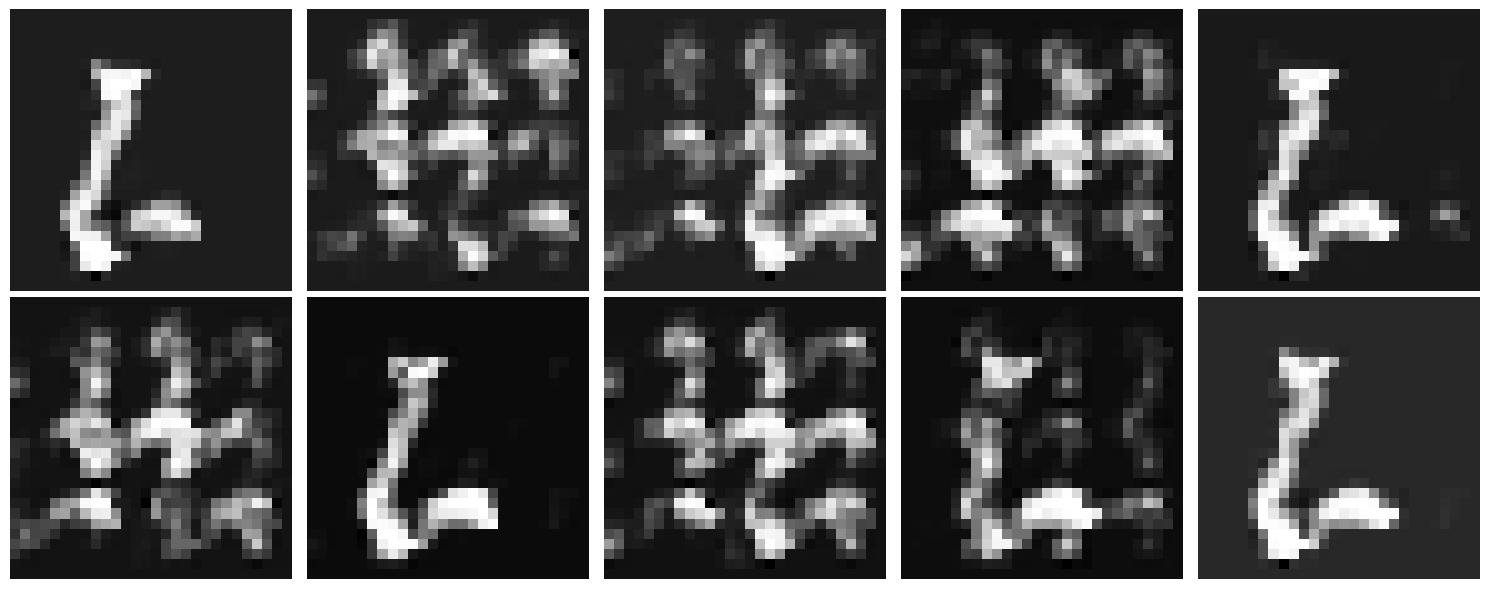

19998it [02:16, 151.44it/s, 2 / 20, disc_loss: 0.5231, gen_loss: 0.7010]

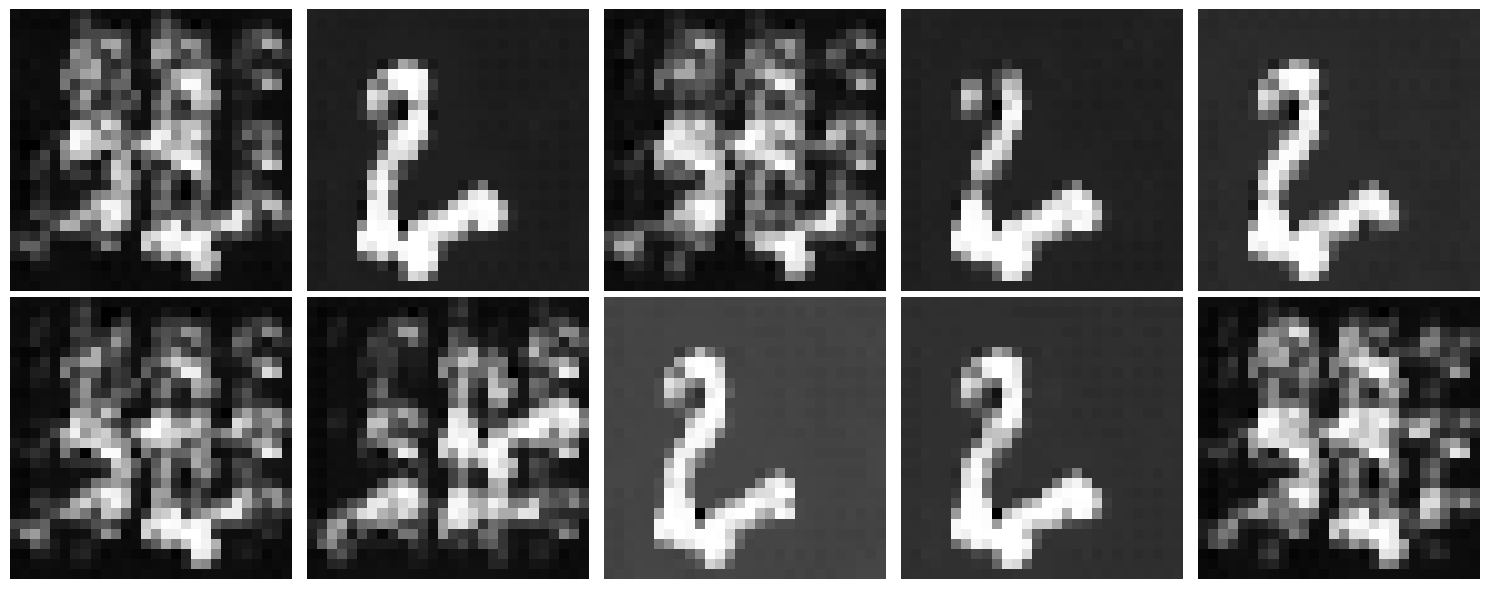

30000it [03:26, 145.55it/s, 2 / 20, disc_loss: 0.5322, gen_loss: 0.7063]
0it [00:00, ?it/s]

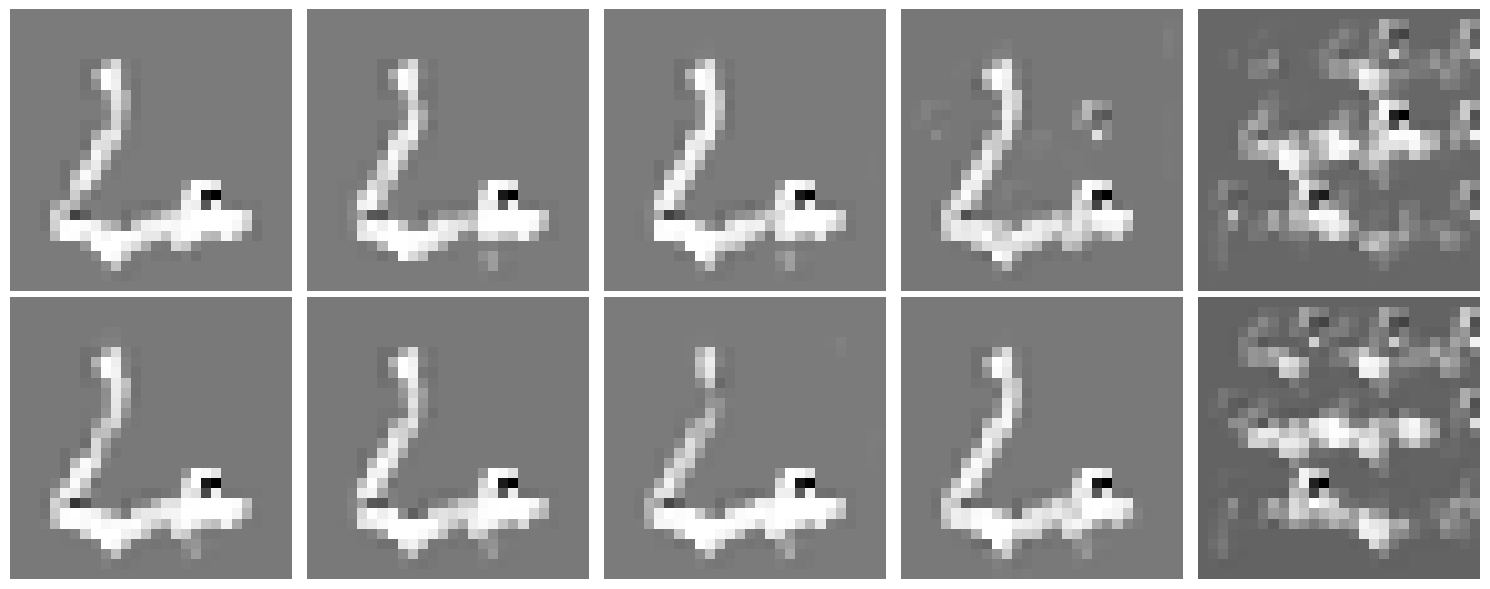

10000it [01:05, 158.16it/s, 3 / 20, disc_loss: 0.5792, gen_loss: 0.7314]

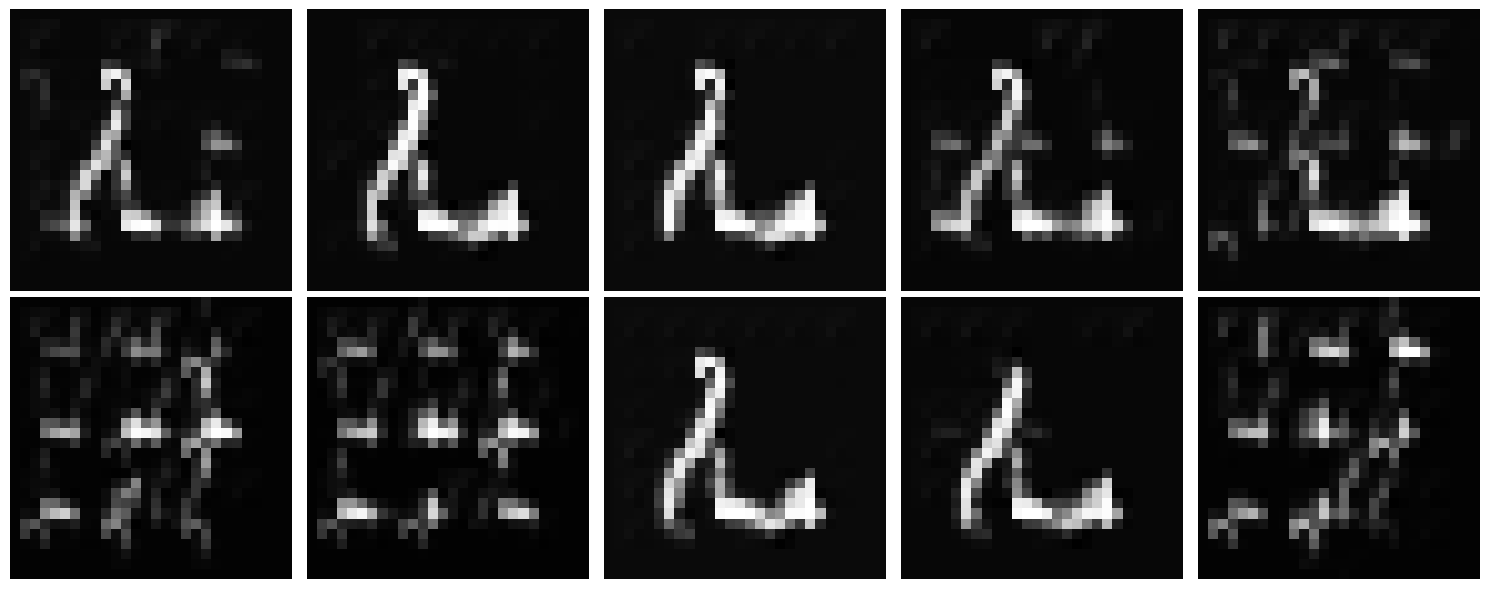

19995it [02:07, 157.91it/s, 3 / 20, disc_loss: 0.5564, gen_loss: 0.7322]

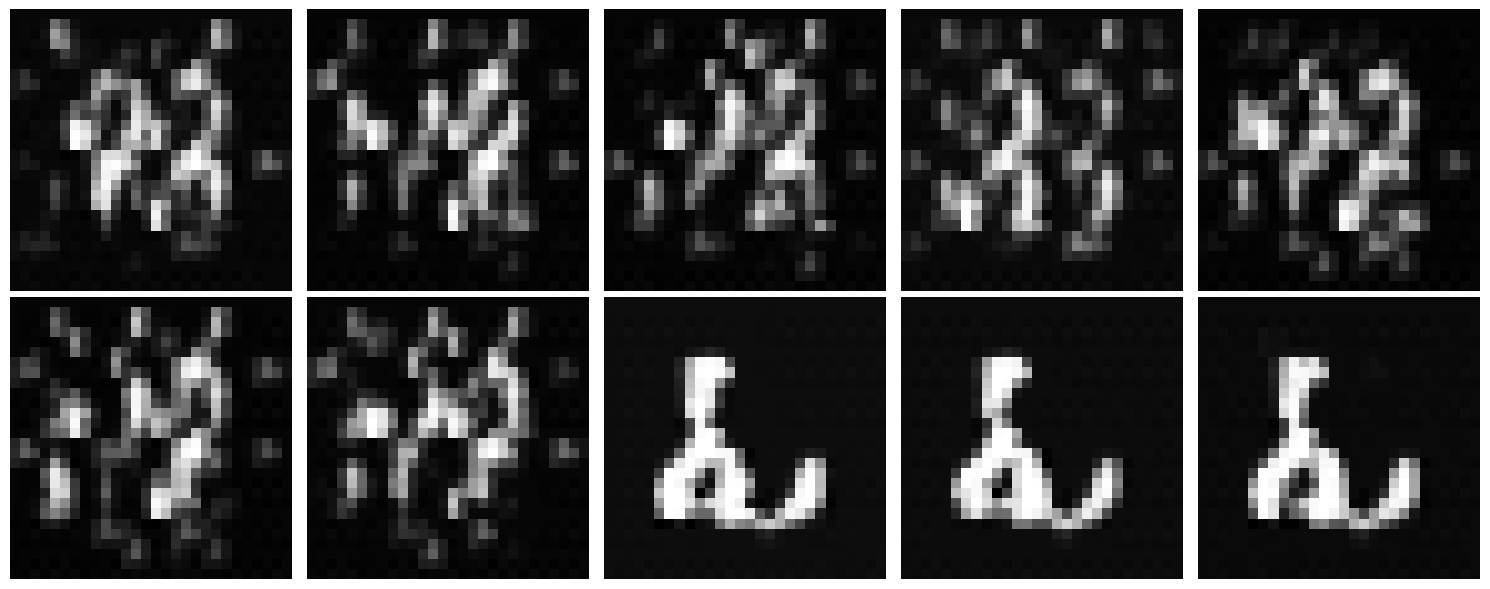

30000it [03:11, 156.98it/s, 3 / 20, disc_loss: 0.5532, gen_loss: 0.7367]
0it [00:00, ?it/s]

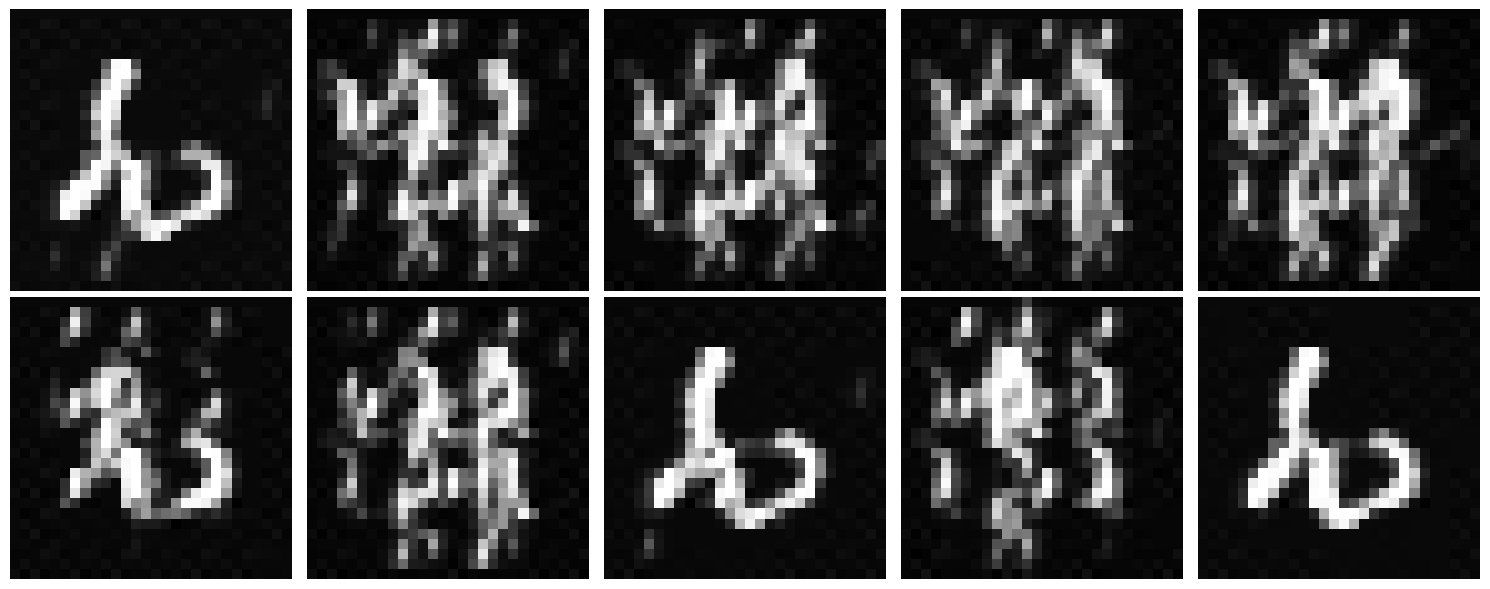

9991it [01:00, 157.50it/s, 4 / 20, disc_loss: 0.5324, gen_loss: 0.7463]

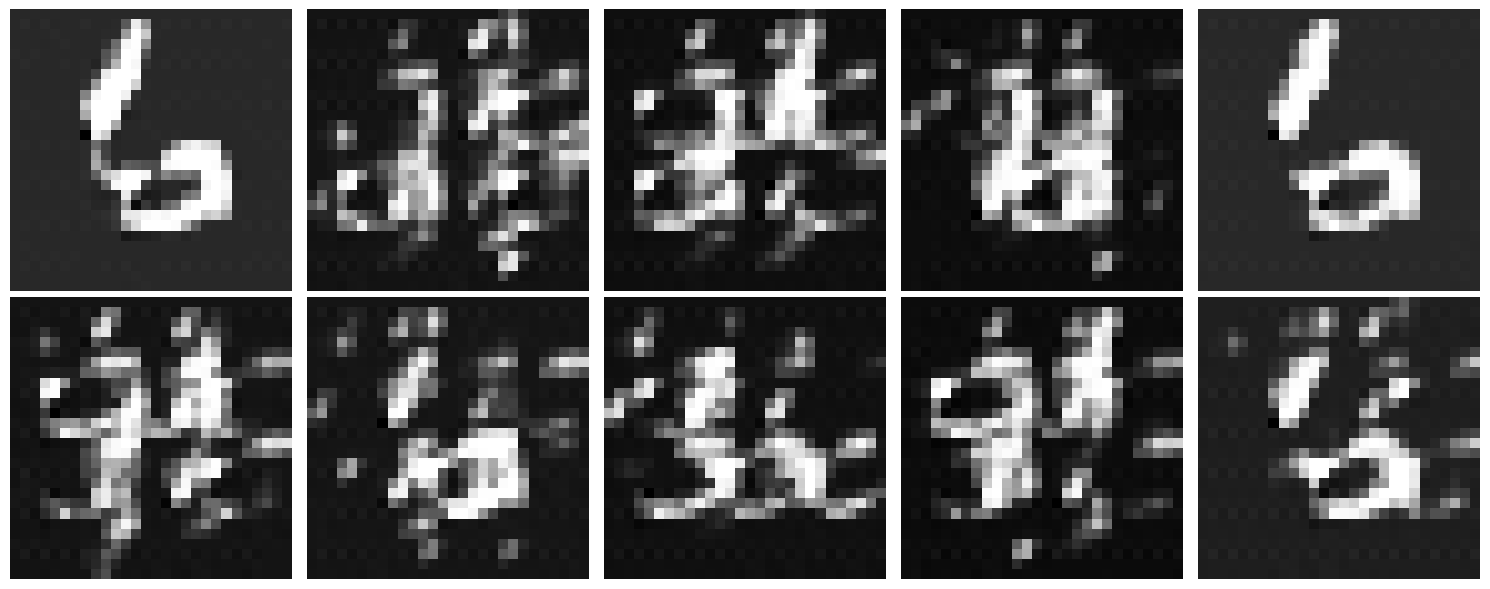

19984it [02:03, 161.75it/s, 4 / 20, disc_loss: 0.5179, gen_loss: 0.7634]

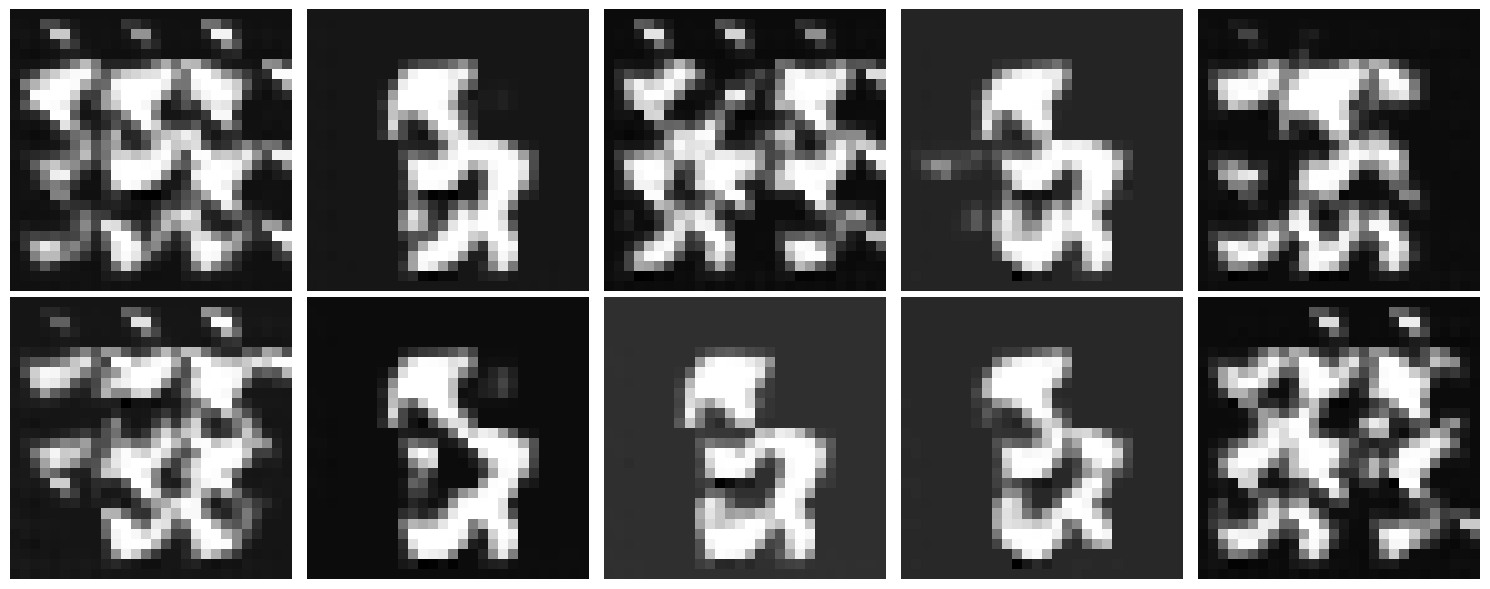

30000it [03:09, 158.39it/s, 4 / 20, disc_loss: 0.5145, gen_loss: 0.7688]
0it [00:00, ?it/s]

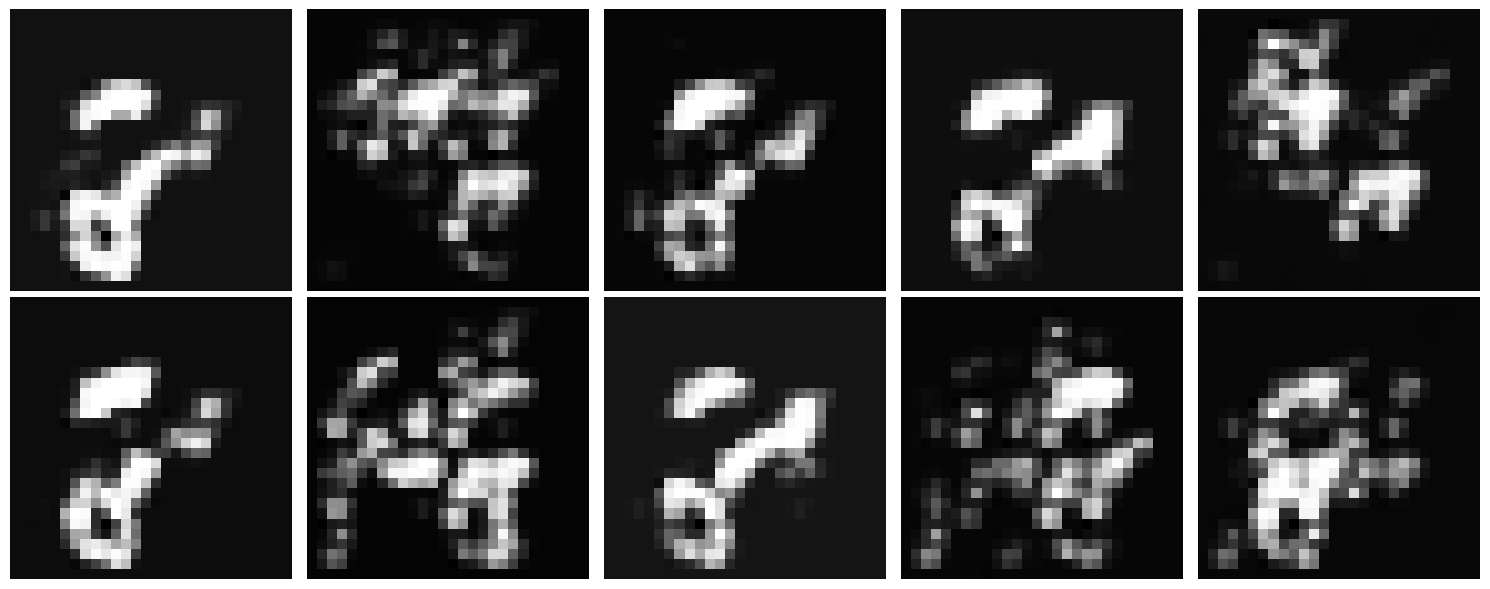

9995it [01:01, 159.38it/s, 5 / 20, disc_loss: 0.4701, gen_loss: 0.8090]

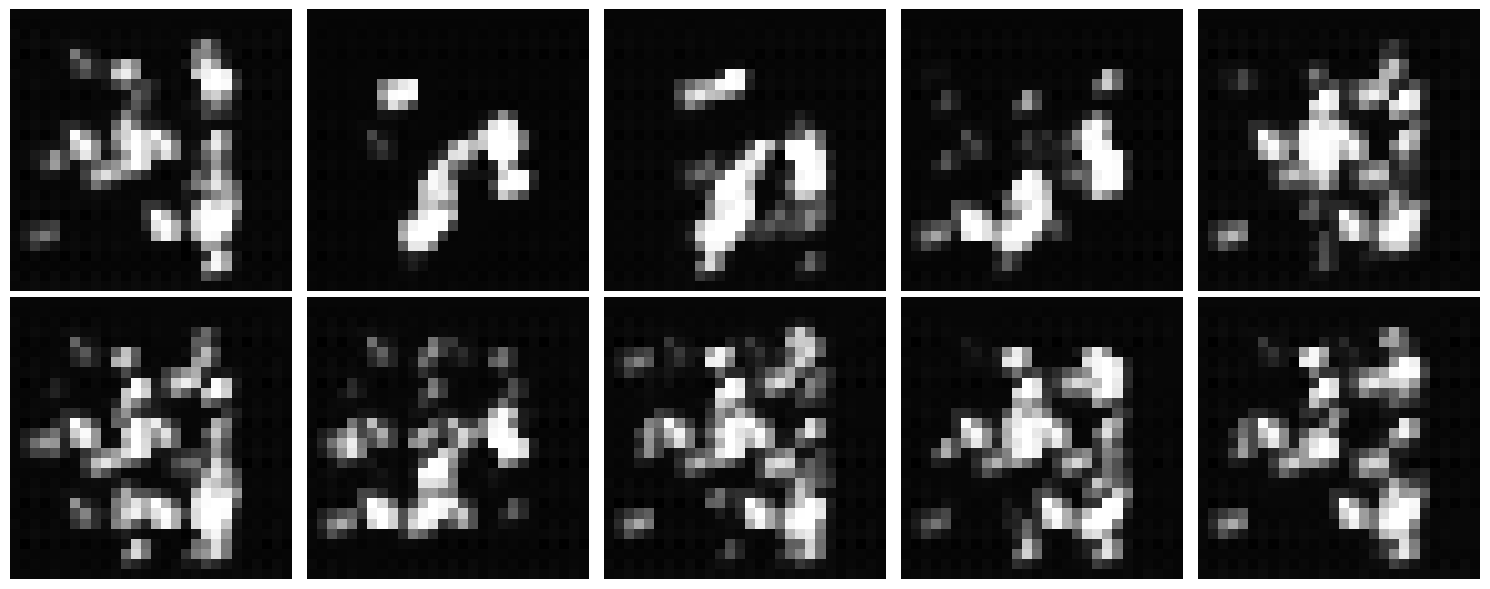

19986it [02:05, 154.59it/s, 5 / 20, disc_loss: 0.4855, gen_loss: 0.8249]

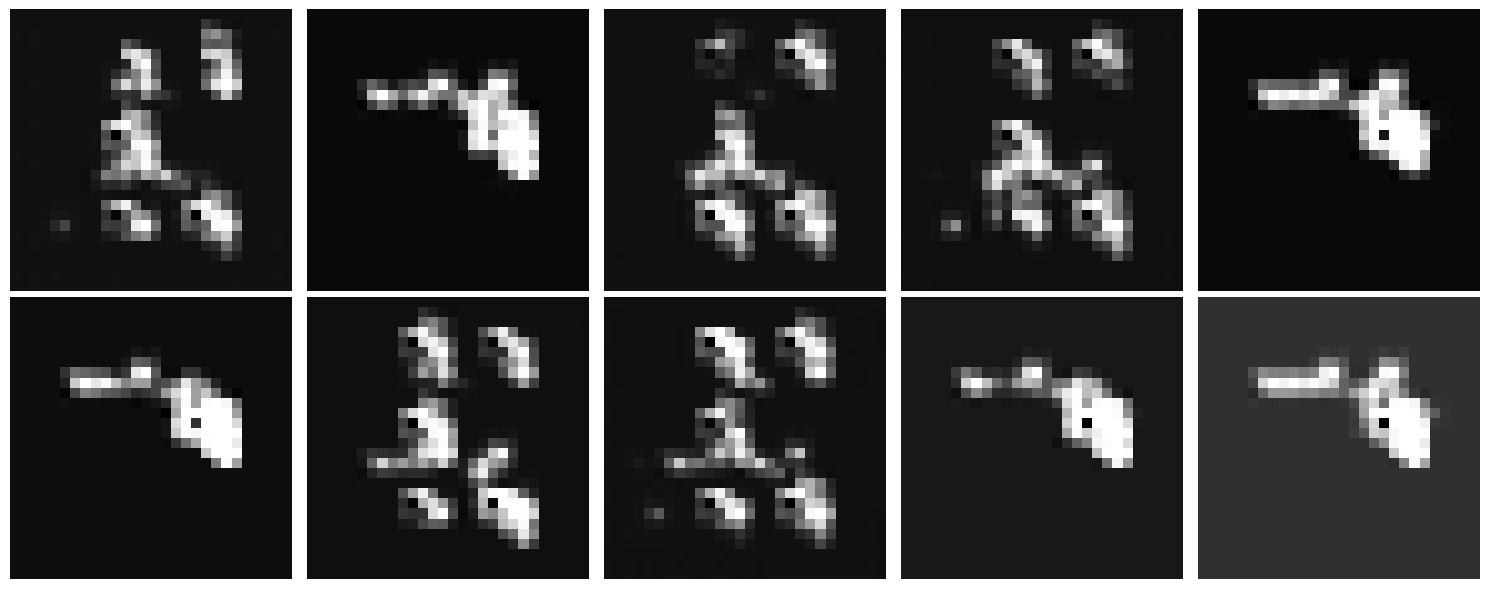

30000it [03:11, 156.78it/s, 5 / 20, disc_loss: 0.4658, gen_loss: 0.8561]
0it [00:00, ?it/s]

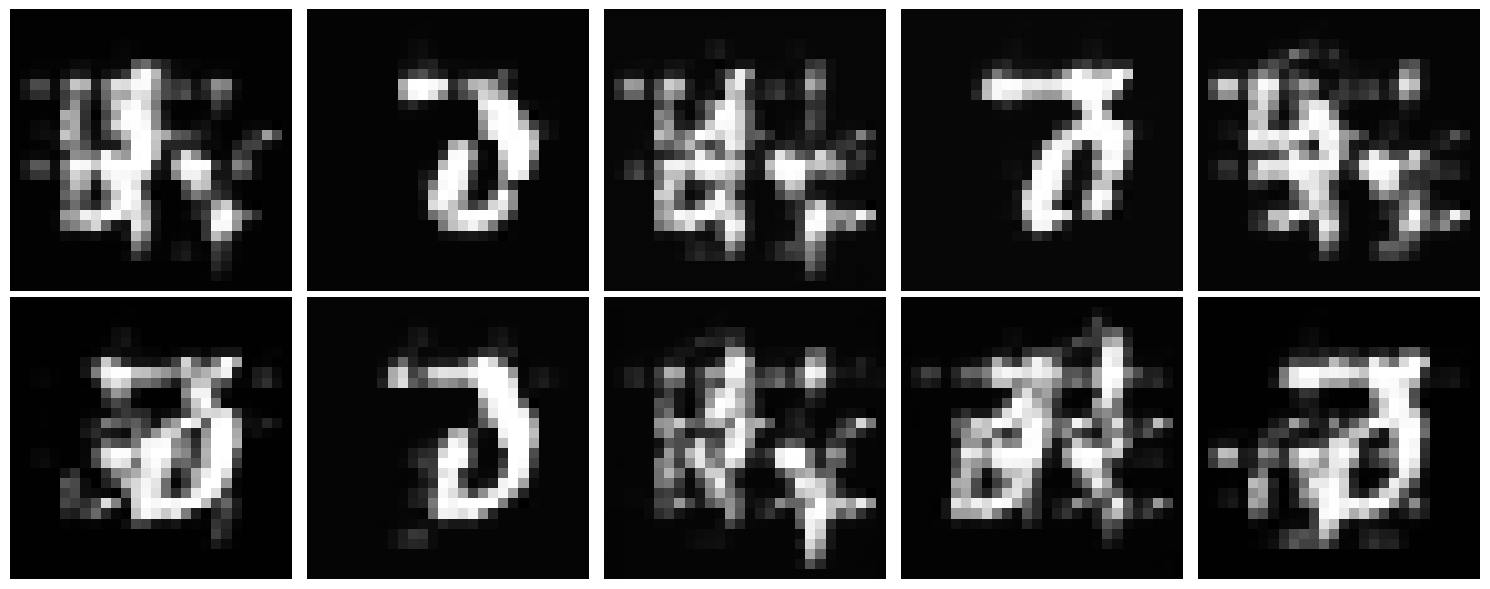

9990it [01:02, 162.57it/s, 6 / 20, disc_loss: 0.5495, gen_loss: 0.7978]

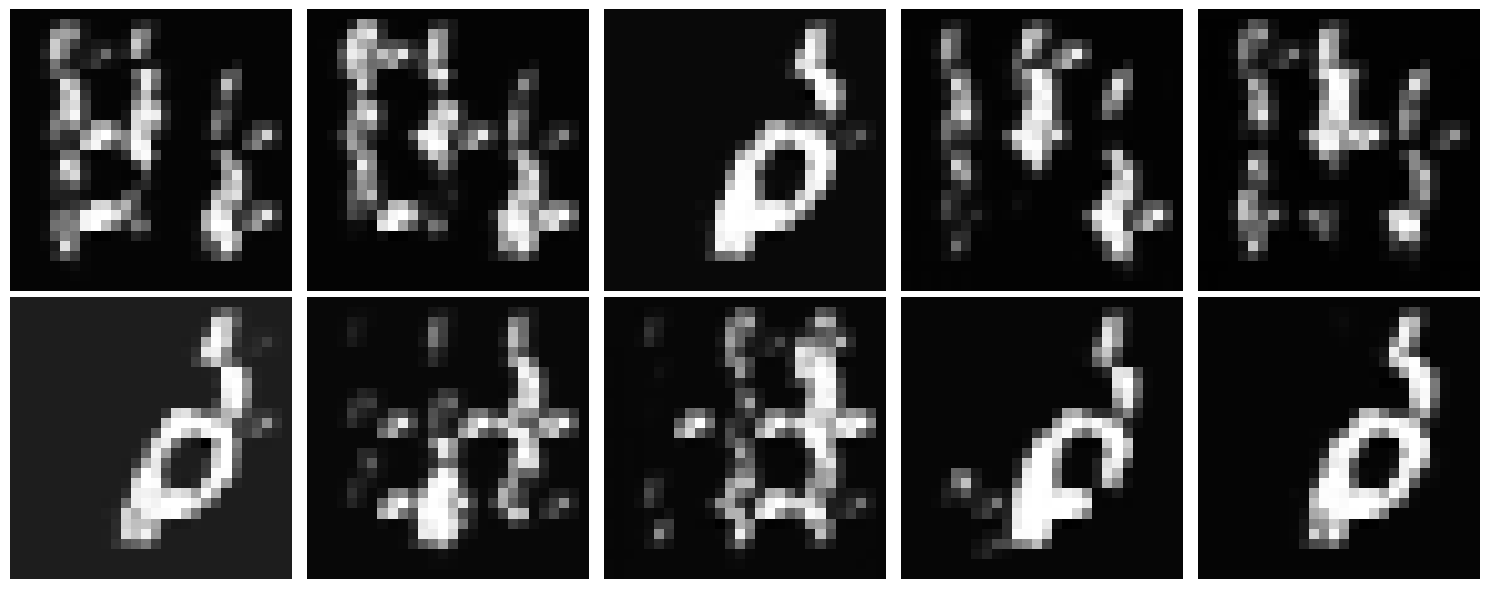

19992it [02:06, 159.13it/s, 6 / 20, disc_loss: 0.5280, gen_loss: 0.8174]

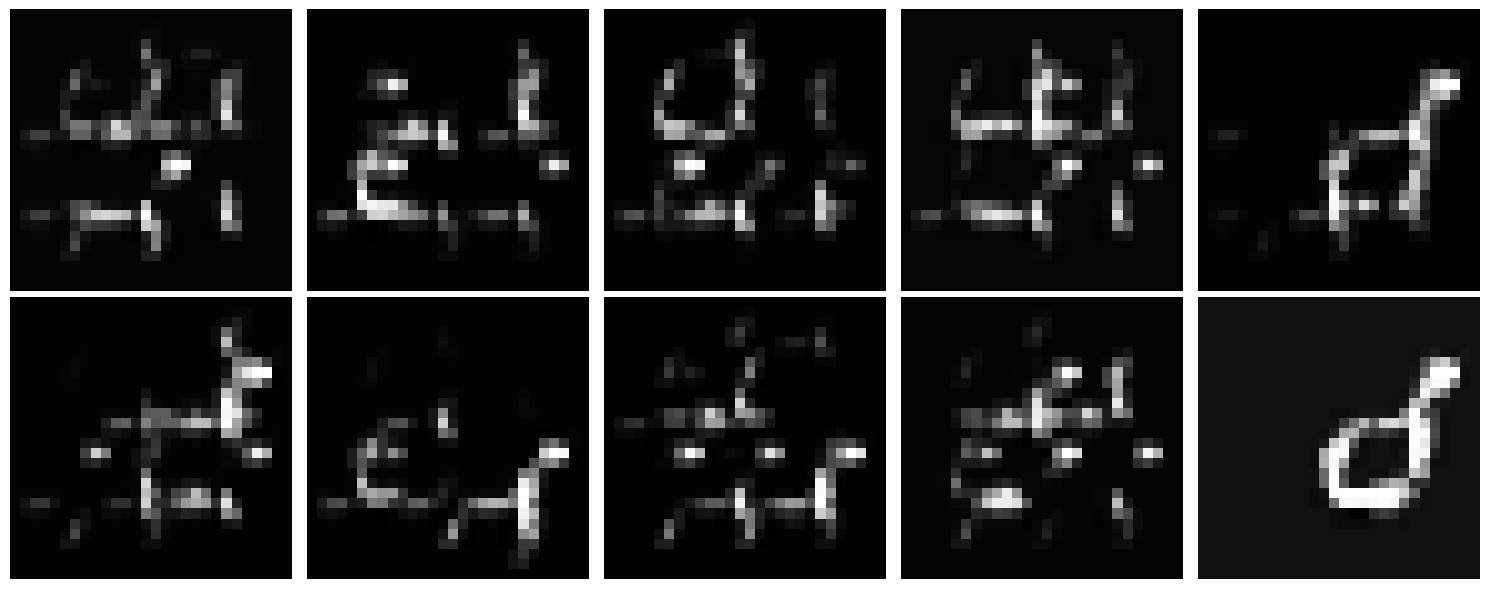

30000it [03:13, 155.11it/s, 6 / 20, disc_loss: 0.5250, gen_loss: 0.8170]
0it [00:00, ?it/s]

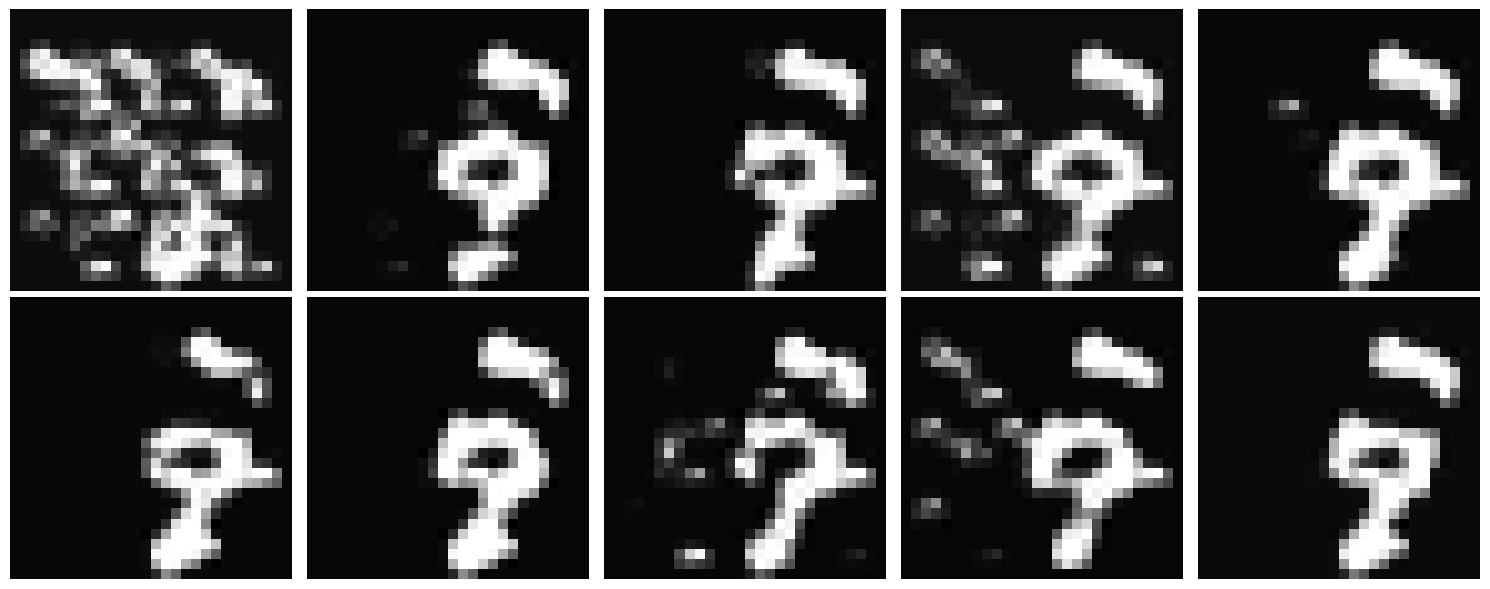

10000it [01:04, 148.15it/s, 7 / 20, disc_loss: 0.4374, gen_loss: 0.8979]

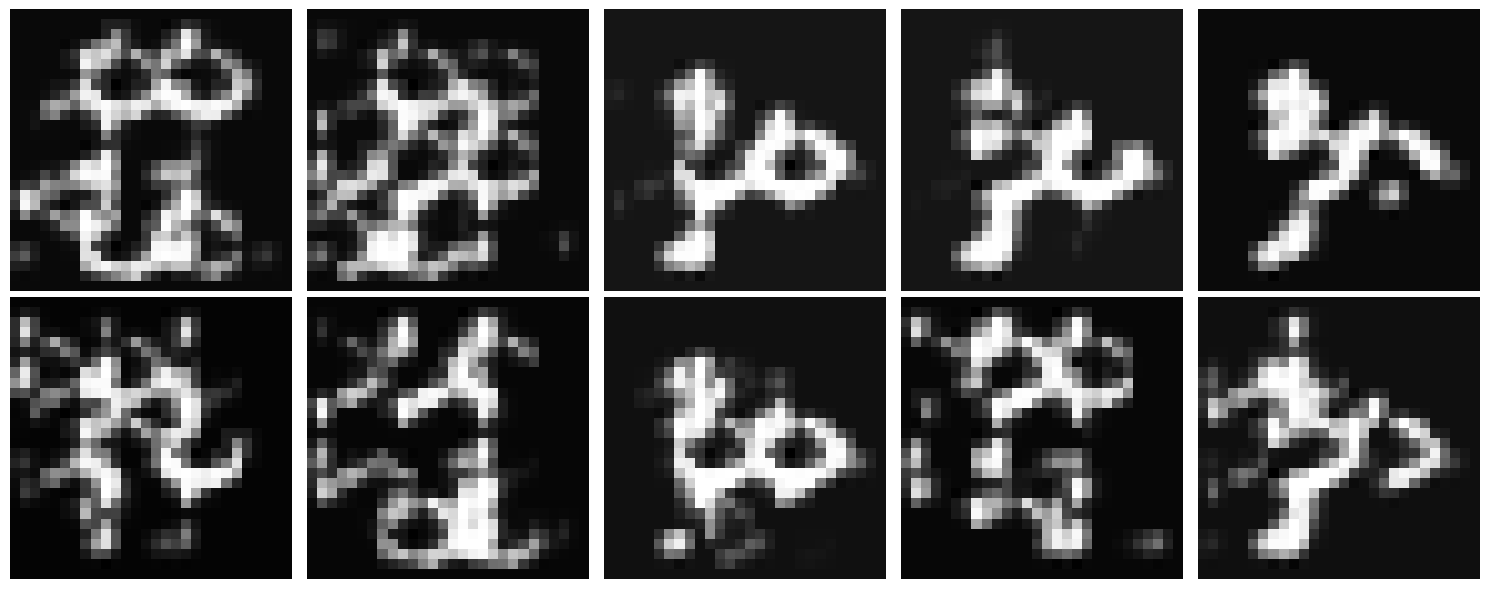

14827it [01:38, 150.98it/s, 7 / 20, disc_loss: 0.4505, gen_loss: 0.8966]


KeyboardInterrupt: 

In [14]:
num_epochs = 20
target = None
succ_count = 0

bestest = float('inf')

for epoch in range(num_epochs):
    disc_losses = []
    gen_losses = []
    step_progress = tqdm(enumerate(loader))
    start_time = time.time()
    
    for step, (x, one_hot ,target) in step_progress:
        loss = train_step(discriminator, x, target, criterion, disc_optimizer)
    
        # one_hot = x[:,-10:]
        batch_size = x.shape[0]
        
        seed = torch.rand([batch_size, 100]).to(device)
        seed = torch.cat([seed, one_hot], dim=1)
        seed = seed.reshape(seed.shape[0], seed.shape[1], 1, 1)
        x = generator(seed)
        target = torch.ones([batch_size, 1]).to(device)
        gen_loss = train_step(discriminator, x, target, criterion, genr_optimizer)

        if step % 10000 == 0:
            show_plt(generator)
        
        gen_losses.append(gen_loss)
        disc_losses.append(loss)
        
        step_progress.set_postfix_str(f"{epoch + 1} / {num_epochs}, disc_loss: {sum(disc_losses)/len(disc_losses):.04f}, gen_loss: {sum(gen_losses)/len(gen_losses):.04f}")
    
    elapsed = int(time.time() - start_time)
    disc_loss = sum(disc_losses)/len(disc_losses)
    gen_loss = sum(gen_losses)/len(gen_losses)
    
    logging.info(f'Epoch {epoch}, elapsed: {elapsed}, DiscLoss: {disc_loss:.04f}, GenLoss: {gen_loss:.04f}')
    
    loss_gap = math.fabs(gen_loss - disc_loss)
    if bestest > loss_gap:
        checkpoint = {
            'epoch': epoch,
            'gen_model_state_dict': generator.state_dict(),
            'disc_model_state_dict': discriminator.state_dict(),
            'gen_optimizer_state_dict': genr_optimizer.state_dict(),
            'disc_optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss': disc_loss,
            'gen_loss': gen_loss,
        }
        torch.save(checkpoint, f'log/checkpoint_{epoch}.pth')
        bestest = loss_gap

    checkpoint = {
        'epoch': epoch,
        'gen_model_state_dict': generator.state_dict(),
        'disc_model_state_dict': discriminator.state_dict(),
        'gen_optimizer_state_dict': genr_optimizer.state_dict(),
        'disc_optimizer_state_dict': disc_optimizer.state_dict(),
        'disc_loss': disc_loss,
        'gen_loss': gen_loss,
    }
    torch.save(checkpoint, f'log/latest.pth')

In [ ]:
checkpoint = torch.load('log/latest.pth')
model = Generator().to(device)
model.load_state_dict(checkpoint['gen_model_state_dict'])

In [ ]:
generator(torch.rand(110).to(device))

In [ ]:
show_plt(model)